In [99]:
import pandas as pd
import numpy as np

# 1. Завантажуємо файл Excel, пропускаючи непотрібні рядки та стовпці
file_path = 'En_In.xls'
Energy = pd.read_excel(file_path, skiprows=17, usecols=[1, 3, 4, 5], names=['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable'])

# Отключаем предупреждение о silent downcasting
pd.set_option('future.no_silent_downcasting', True)

# 2. Переводимо 'Energy Supply' з ПДж у ГДж
Energy['Energy Supply'] = pd.to_numeric(Energy['Energy Supply'], errors='coerce') * 1000000

# Замінюємо "..." на np.NaN для відсутніх значень
Energy.replace("...", np.nan, inplace=True)

# Если нужно заменить Inf на NaN
Energy.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Перейменовуємо країни
Energy['Country'] = Energy['Country'].replace({
    "Republic of Korea": "South Korea",
    "United States of America": "United States",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "China, Hong Kong Special Administrative Region": "Hong Kong"
})

# 4. Видаляємо цифри і дужки з назв країн
Energy['Country'] = Energy['Country'].str.replace(r"\(.*\)", "", regex=True).str.replace(r"\d+", "", regex=True).str.strip()

# Округлюємо до трьох знаків після коми у стовпці '% Renewable'
Energy['% Renewable'] = Energy['% Renewable'].round(3)

In [100]:
Energy.loc[Energy['Country'].isin(['American Samoa', 'South Korea', 'Bolivia' ])]

,Country,Energy Supply,Energy Supply per Capita,% Renewable
3,American Samoa,NaN,NaN,0.641
24,Bolivia,336000000.000,32,31.477
164,South Korea,11007000000.000,221,2.279


In [101]:
# Завантажуємо файл CSV, пропускаючи заголовок
file_path = 'gpd.csv'
GDP = pd.read_csv(file_path, skiprows=4)

# Перейменовуємо країни згідно з інструкціями
GDP['Country Name'] = GDP['Country Name'].replace({
    "Korea, Rep.": "South Korea",
    "Iran, Islamic Rep.": "Iran",
    "Hong Kong SAR, China": "Hong Kong"
})
pd.set_option('display.max_columns', 15)


In [37]:
GDP.head(1) 

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,...,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,...,NaN,2467703910.615,NaN,NaN,NaN,NaN,NaN


In [60]:
# 6. Завантажуємо дані з файлу Excel
file_path = 'scimagojr.xlsx'
scimagojr_data = pd.read_excel(file_path)

# Виводимо перші кілька рядків, щоб перевірити дані
scimagojr_data.head()

,Rank,Country,Documents,Citable documents,Citations,Self-citations,Citations per document,H index
0,1,China,127050,126767,597237,411683,4.700,138
1,2,United States,96661,94747,792274,265436,8.200,230
2,3,Japan,30504,30287,223024,61554,7.310,134
3,4,United Kingdom,20944,20357,206091,37874,9.840,139
4,5,Russian Federation,18534,18301,34266,12422,1.850,57


In [73]:
# Вибираємо лише 15 країн з найвищим рейтингом
scimagojr_data = scimagojr_data[scimagojr_data['Rank'] <= 15]

# Об'єднуємо дані Scimagojr і енергоспоживання
merged_data = pd.merge(scimagojr_data, Energy, how='inner', left_on='Country', right_on='Country')

# Об'єднуємо з даними по ВВП
final_data = pd.merge(merged_data, GDP, how='inner', left_on='Country', right_on='Country Name')

# Вибираємо необхідні стовпці для фінальної таблиці
columns_needed = ['Country', 'Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
                  'Citations per document', 'H index', 'Energy Supply', 'Energy Supply per Capita', '% Renewable'] + [str(year) for year in range(2006, 2016)]
Result = final_data[columns_needed]

# Відбираємо тільки 15 країн після об'єднання
Result = Result[Result['Rank'] <= 15]

# Устанавливаем 'Country' как индекс
Result.set_index('Country', inplace=True)


In [74]:
Result.head(3)

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,...,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.700,138,...,5459247267275.140,6039658508485.590,6612490294273.650,7124977970399.610,7672447738017.420,8230120617793.520,8797998940421.279
United States,2,96661,94747,792274,265436,8.200,230,...,14594842181900.000,14964372000000.000,15204019634600.000,15542161722300.000,15773666098800.000,16156618476000.000,16548573278300.000
Japan,3,30504,30287,223024,61554,7.310,134,...,5251308399909.320,5498717815809.770,5473738114222.050,5569101602926.180,5644658523313.420,5642884448582.190,5669563143140.970


In [75]:
Result.shape

(15, 20)

In [103]:
def task_eight():
    # Вибираємо стовпці з ВВП за останні 10 років (2006-2015)
    gdp_columns = [str(year) for year in range(2006, 2016)]
    
    # Обчислюємо середнє значення ВВП для кожної країни
    avg_gdp = Result[gdp_columns].mean(axis=1)
    
    # Повертаємо відсортований об'єкт Series за спаданням
    return avg_gdp.sort_values(ascending=False)


In [102]:
task_eight()

Country
United States        15364344302990.000
China                 6348608932836.100
Japan                 5542207638235.176
Germany               3493025339072.848
France                2681724635761.589
United Kingdom        2487906661418.417
Brazil                2189794143774.905
Italy                 2120175089933.776
India                 1769297396603.860
Canada                1660647466307.512
Russian Federation    1565459478480.661
Spain                 1418078278145.694
Australia             1164042729991.427
South Korea           1106714508244.852
Iran                   444155754051.095
dtype: float64

In [79]:
def task_nine():
    # Отримуємо середній ВВП для всіх країн і сортуємо
    avg_gdp = task_eight()
    
    # Знаходимо країну з 5-м середнім ВВП
    fifth_country = avg_gdp.index[4]
    
    # Визначаємо зміну ВВП між 2006 і 2015 роками для цієї країни
    gdp_change = Result.loc[fifth_country, '2015'] - Result.loc[fifth_country, '2006']
    
    # Повертаємо кортеж з назвою країни та зміною ВВП
    return (fifth_country, gdp_change)

In [80]:
task_nine()

('France', 153345695364.24023)

In [83]:
def task_ten():
    # Знаходимо країну з максимальним значенням у стовпці % Renewable
    max_renewable = Result['% Renewable'].idxmax()  # Назва країни
    max_value = Result['% Renewable'].max()  # Максимальне значення
    
    # Повертаємо кортеж із назвою країни та значенням
    return (max_renewable, max_value)

In [82]:
task_ten()

('Brazil', 69.648)

In [84]:
def task_eleven():
    # Оцінюємо чисельність населення
    Result['Estimated Population'] = Result['Energy Supply'] / Result['Energy Supply per Capita']
    
    # Знаходимо країну з 6-м найбільшим населенням
    sixth_population_country = Result['Estimated Population'].sort_values(ascending=False).index[5]
    sixth_population_value = Result['Estimated Population'].sort_values(ascending=False).iloc[5]
    
    # Повертаємо кортеж із назвою країни та її населенням
    return (sixth_population_country, sixth_population_value)

In [85]:
task_eleven()

('Japan', 127409395.97315437)

In [88]:
def task_twelve():
    # Додаємо стовпець із кількістю цитованих документів на душу населення
    Result['Citations per Capita'] = Result['Citations'] / Result['Estimated Population']
    
    # Видаляємо рядки з NaN у ключових стовпцях перед обчисленням кореляції
    clean_data = Result[['Citations per Capita', 'Energy Supply per Capita']].dropna()
    
    # Обчислюємо кореляцію між 'Citations per Capita' і 'Energy Supply per Capita'
    correlation = clean_data['Citations per Capita'].corr(clean_data['Energy Supply per Capita'])
    
    # Повертаємо результат кореляції
    return correlation

In [89]:
task_twelve()

0.6668248468590926

In [90]:
def task_thirteen():
    # Обчислюємо медіану для стовпця % Renewable
    renewable_median = Result['% Renewable'].median()
    
    # Створюємо новий стовпець: 1, якщо значення % Renewable >= медіани, і 0, якщо менше
    Result['Renewable Above Median'] = (Result['% Renewable'] >= renewable_median).astype(int)
    
    # Повертаємо новий стовпець із назвою країни як індекс, відсортований за Rank
    return Result[['Renewable Above Median', 'Rank']].sort_values(by='Rank')['Renewable Above Median']



In [91]:
task_thirteen()

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: Renewable Above Median, dtype: int64

In [93]:
def task_fourteen():
    # Створюємо словник континентів
    ContinentDict = {
        'China':'Asia', 'United States':'North America', 'Japan':'Asia',
        'United Kingdom':'Europe', 'Russian Federation':'Europe',
        'Canada':'North America', 'Germany':'Europe', 'India':'Asia',
        'France':'Europe', 'South Korea':'Asia', 'Italy':'Europe',
        'Spain':'Europe', 'Iran':'Asia', 'Australia':'Australia', 'Brazil':'South America'
    }

    # Додаємо стовпець Continent до датафрейму
    Result['Continent'] = Result.index.to_series().map(ContinentDict)
    
    # Створюємо новий DataFrame, згрупований за континентами
    grouped = Result.groupby('Continent')['Estimated Population'].agg(['size', 'sum', 'mean', 'std'])
    
    # Повертаємо DataFrame
    return grouped

In [94]:
task_fourteen()

,size,sum,mean,std
Continent,,,,
Asia,5,2898666386.611,579733277.322,679097888.366
Australia,1,23316017.316,23316017.316,NaN
Europe,6,457929667.216,76321611.203,34647667.066
North America,2,352855249.480,176427624.740,199669644.857
South America,1,205915254.237,205915254.237,NaN


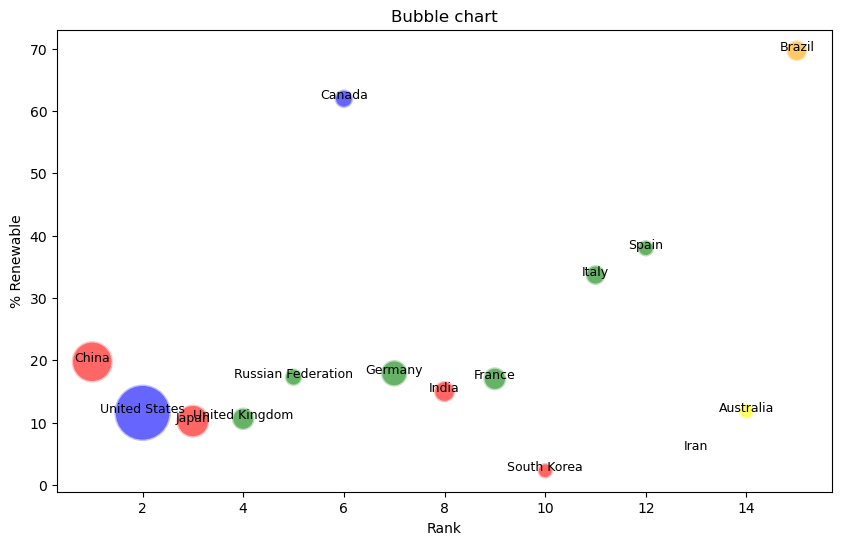

In [98]:
def task_fifteen():
    # Створюємо колірну мапу для континентів
    ContinentDict = {
        'Asia': 'red', 'Europe': 'green', 'North America': 'blue', 
        'South America': 'orange', 'Australia': 'yellow'
    }

    # Додаємо кольори до нашого датафрейму відповідно до континенту
    Result['Color'] = Result['Continent'].map(ContinentDict)

    # Створюємо фігуру та підграфік
    plt.figure(figsize=(10, 6))

    # Будуємо бульбашкову діаграму
    plt.scatter(
        x=Result['Rank'],  # Вісь x: Рейтинг
        y=Result['% Renewable'],  # Вісь y: Відсоток відновлюваної енергії
        s=Result['2015'] / 10**10,  # Розмір бульбашок відповідає ВВП у 2015 році (масштабуємо)
        c=Result['Color'],  # Колір бульбашок відповідає континенту
        alpha=0.6, edgecolors="w", linewidth=2
    )

    # Додаємо підписи для кожної країни
    for i in range(len(Result)):
        plt.text(Result['Rank'].iloc[i], Result['% Renewable'].iloc[i], Result.index[i], fontsize=9, ha='center')

    # Налаштовуємо заголовок та підписи осей
    plt.title('Bubble chart')
    plt.xlabel('Rank')
    plt.ylabel('% Renewable')

    # Відображаємо діаграму
    plt.show()

# Викликаємо функцію для побудови діаграми
task_fifteen()